# PART 3 - Activation/Gradient/BatchNorm tuning

In [6]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
# read in all names
words = open('names.txt', 'r').read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [8]:
len(words)

32033

In [9]:
# build vocab
chars = sorted(
    list( set(''.join(words) ) )
)
stoi = {s:i+1 for i, s in enumerate(chars) }
stoi['.'] = 0
itos = {i:s for s, i in stoi.items() }
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [10]:
# build dataset
block_size = 3

def build_dataset(words):
    
    X, Y = [], [] # inputs, targets
    
    for w in words:
        # print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context) # context words
            Y.append(ix)
            # print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)

    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

# train/dev/test split
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [20]:
n_embed = 10 # embedding size
n_hidden = 200 # hidden state size (neuron size)
vocab_size = len(itos)

g = torch.Generator().manual_seed(2147483647) # reproducibility
# embedding, 2d for each vocab, 27 total
C = torch.randn((vocab_size, n_embed), generator=g)
# layer 1, [context, hidden_size]=[3 word embedding, 100]=[6, 100]
W1 = torch.randn((n_embed * block_size, n_hidden), generator=g) * (5/3)*((n_embed * block_size)**-0.5)
# no bias needed because we have batch normalization, which has its own bias
# b1 = torch.randn(n_hidden, generator=g) * 0.01
# layer 2, [100, 27], output softmax
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
for p in parameters:
    p.requires_grad = True

sum(p.nelement() for p in parameters) # total number of params in network

12097

In [21]:
max_steps = 200000
report_interval = max_steps / 100
batch_size = 32
lossi = []

for i in range(max_steps):
    # mini batch indices
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward pass
    emb = C[Xb] # [32, 3, 2]
    embcat = emb.view(emb.shape[0], -1) # embedding concat based on context size

    # ------ Linear layer
    hpreact = embcat @ W1 #+ b1

    # ------ BatchNorm layer
    # apply batch normailization so it is normal distributed.
    # issue: hidden state no longer deterministic, and tied to mean/std of the batch
    # this causes the value to jitter.
    # - a bug? undersireable?
    # - data augmentation due to jitter
    # - introducing noise prevents overfitting - i.e. Regularization
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
    
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

    # ------- Non-linearity layer
    h = torch.tanh(hpreact) # [32, 100]
    logits = h @ W2 + b2 # [32, 27]
    loss = F.cross_entropy(logits, Yb)

    print(loss.shape, logits.shape, Yb.shape)
    # backward pass
    for p in parameters:
        # reset gradient
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < max_steps / 2 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    # lri.append(lre[i])
    if i % report_interval == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    if i >= 100: # delete early breaking if we are ready to train all the way
        break

print(loss.item())

torch.Size([]) torch.Size([32, 27]) torch.Size([32])
      0/ 200000: 3.3239
torch.Size([]) torch.Size([32, 27]) torch.Size([32])
torch.Size([]) torch.Size([32, 27]) torch.Size([32])
torch.Size([]) torch.Size([32, 27]) torch.Size([32])
torch.Size([]) torch.Size([32, 27]) torch.Size([32])
torch.Size([]) torch.Size([32, 27]) torch.Size([32])
torch.Size([]) torch.Size([32, 27]) torch.Size([32])
torch.Size([]) torch.Size([32, 27]) torch.Size([32])
torch.Size([]) torch.Size([32, 27]) torch.Size([32])
torch.Size([]) torch.Size([32, 27]) torch.Size([32])
torch.Size([]) torch.Size([32, 27]) torch.Size([32])
torch.Size([]) torch.Size([32, 27]) torch.Size([32])
torch.Size([]) torch.Size([32, 27]) torch.Size([32])
torch.Size([]) torch.Size([32, 27]) torch.Size([32])
torch.Size([]) torch.Size([32, 27]) torch.Size([32])
torch.Size([]) torch.Size([32, 27]) torch.Size([32])
torch.Size([]) torch.Size([32, 27]) torch.Size([32])
torch.Size([]) torch.Size([32, 27]) torch.Size([32])
torch.Size([]) torch.S

### Distribution of hidden state

#### intuition

tensor(-0.0157) tensor(0.9994)
tensor(0.0032) tensor(3.0842)


(array([6.37472180e-06, 6.37472180e-06, 1.91241654e-05, 0.00000000e+00,
        1.27494436e-05, 0.00000000e+00, 3.18736090e-05, 4.46230526e-05,
        5.73724962e-05, 1.40243880e-04, 1.84866932e-04, 2.74113037e-04,
        5.60975518e-04, 1.14744992e-03, 1.59368045e-03, 2.84950064e-03,
        4.66629636e-03, 7.90465503e-03, 1.25390778e-02, 2.03927350e-02,
        3.07962810e-02, 4.52987731e-02, 6.45121846e-02, 8.78436664e-02,
        1.10333685e-01, 1.28546265e-01, 1.38420709e-01, 1.37254135e-01,
        1.24071210e-01, 1.04067333e-01, 8.00218828e-02, 5.79589706e-02,
        4.11807028e-02, 2.73858049e-02, 1.72627466e-02, 1.11748873e-02,
        6.85920066e-03, 3.84395725e-03, 2.21202846e-03, 1.42793768e-03,
        8.41463278e-04, 5.48226075e-04, 3.44234977e-04, 1.72117489e-04,
        7.01219398e-05, 1.91241654e-05, 1.27494436e-05, 1.27494436e-05,
        6.37472180e-06, 1.27494436e-05]),
 array([-21.05399895, -20.26965099, -19.48530304, -18.70095509,
        -17.91660713, -17.1322

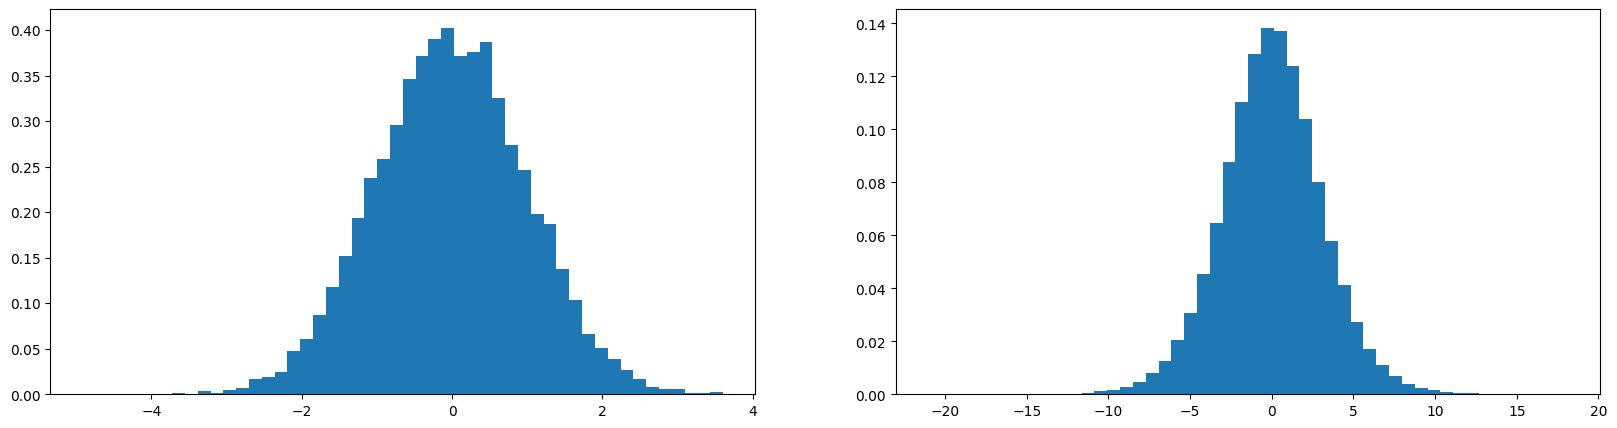

In [57]:
# normal dist input of 1000 samples, each dim 10
x = torch.randn(1000, 10)
# weights 200 neurons
w = torch.randn(10, 200)
# hidden state
y = x @ w

# mean/std of data
print(x.mean(), x.std())
# mean/std of hidden state
print(y.mean(), y.std())

plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True)

plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True)

we see that the multiplication of 2 initially normal distributed matrices `x` and `w` results in more spread out distributed hidden state `y`.

to keep foward/backward pass well behaved, we want to have the initial hidden state `y` to be normal distributed, or having _std_ close to 1.

to do this, we do
- apply normalizing factor `(fan_in)**-0.5` to `w`
- apply gain factor `5/3` for activation function `tanh`, different activation function gains are listed [here](https://pytorch.org/docs/stable/nn.init.html)

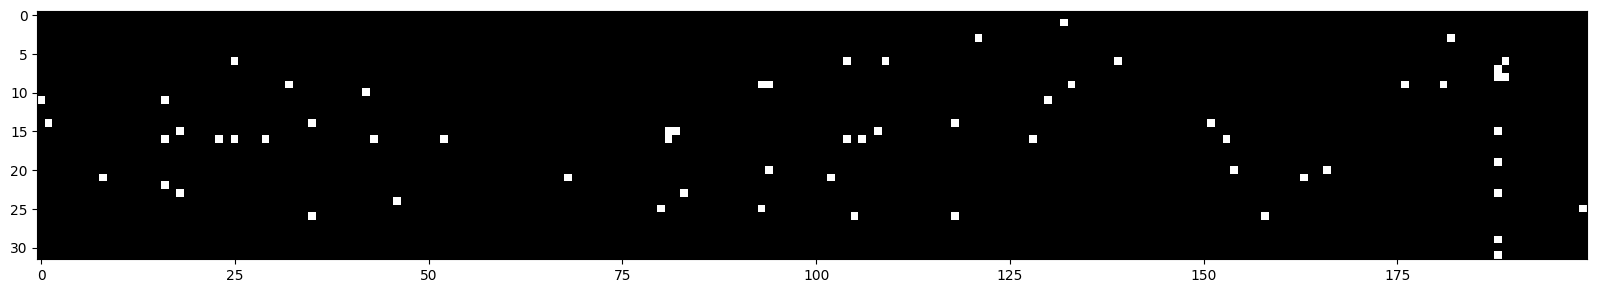

In [51]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

(array([  1.,   2.,   0.,   1.,   5.,   3.,  11.,   6.,  13.,  10.,  25.,
         40.,  40.,  77.,  63., 101., 127., 171., 184., 220., 227., 267.,
        312., 301., 356., 367., 376., 360., 370., 331., 298., 278., 292.,
        242., 191., 167., 137., 104.,  85.,  77.,  41.,  30.,  28.,  20.,
         11.,   7.,  11.,   5.,   2.,   7.]),
 array([-3.76367092, -3.62009715, -3.47652338, -3.33294961, -3.18937584,
        -3.04580207, -2.9022283 , -2.75865453, -2.61508076, -2.47150699,
        -2.32793322, -2.18435945, -2.04078568, -1.8972119 , -1.75363813,
        -1.61006436, -1.46649059, -1.32291682, -1.17934305, -1.03576928,
        -0.89219551, -0.74862174, -0.60504797, -0.4614742 , -0.31790043,
        -0.17432666, -0.03075289,  0.11282088,  0.25639465,  0.39996842,
         0.54354219,  0.68711596,  0.83068974,  0.97426351,  1.11783728,
         1.26141105,  1.40498482,  1.54855859,  1.69213236,  1.83570613,
         1.9792799 ,  2.12285367,  2.26642744,  2.41000121,  2.55357498,
 

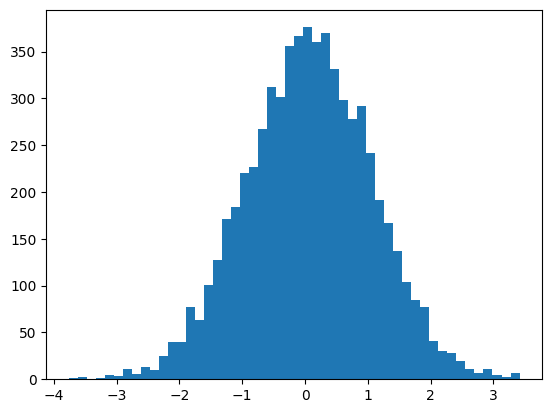

In [49]:
plt.hist(hpreact.view(-1).tolist(), 50)

(array([143., 172., 172., 161., 142., 151., 133., 116., 116., 143.,  95.,
        104., 126., 111., 119.,  91.,  86.,  90., 115., 100., 112., 122.,
        111.,  77., 103., 119., 100., 106.,  91.,  90., 117., 114., 116.,
        115., 107., 131., 111., 109., 114., 118., 142., 127., 162., 169.,
        152., 197., 184., 192., 208., 198.]),
 array([-9.98924255e-01, -9.58988956e-01, -9.19053657e-01, -8.79118358e-01,
        -8.39183059e-01, -7.99247760e-01, -7.59312460e-01, -7.19377161e-01,
        -6.79441862e-01, -6.39506563e-01, -5.99571264e-01, -5.59635965e-01,
        -5.19700665e-01, -4.79765366e-01, -4.39830067e-01, -3.99894768e-01,
        -3.59959469e-01, -3.20024170e-01, -2.80088871e-01, -2.40153571e-01,
        -2.00218272e-01, -1.60282973e-01, -1.20347674e-01, -8.04123747e-02,
        -4.04770756e-02, -5.41776419e-04,  3.93935227e-02,  7.93288219e-02,
         1.19264121e-01,  1.59199420e-01,  1.99134719e-01,  2.39070019e-01,
         2.79005318e-01,  3.18940617e-01,  3.58875

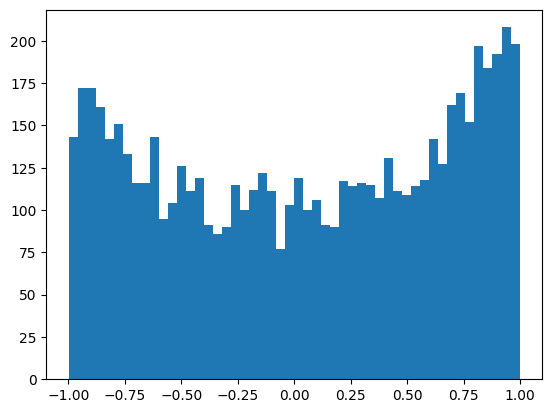

In [50]:
plt.hist(h.view(-1).tolist(), 50)

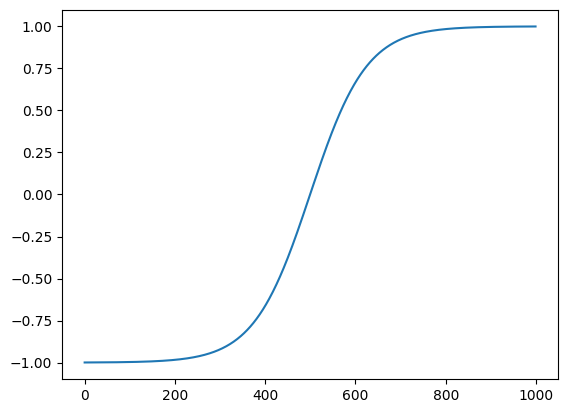

In [35]:
plt.plot(torch.tanh(torch.linspace(-4,4, 1000)))

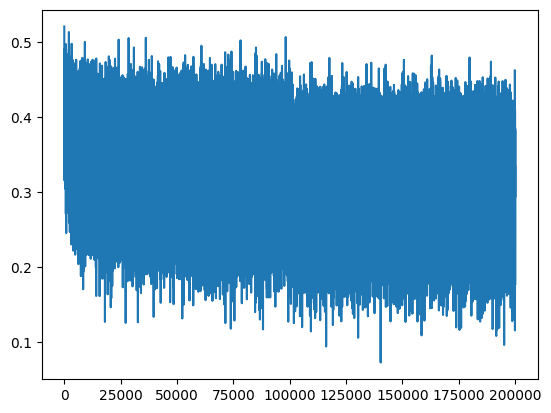

In [55]:
plt.plot(lossi)

In [ ]:
with torch.no_grad():
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    # measure the mean/std over training set
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

In [73]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]

    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    
    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0674195289611816
val 2.105670928955078


In [56]:
# sample from current model
g = torch.Generator().manual_seed(2147483647 + 10) # reproducibility

# generate 20 names
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])] # start with '...'
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()

        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

carmahzauri.
jai.
kimri.
reh.
casparsha.
jazhith.
deliah.
jareei.
nellara.
chaily.
kaleigh.
ham.
jorn.
quint.
salin.
alianni.
waythoniearyn.
kai.
euliyuan.
eddeli.


In [74]:
# ----------- Summary

In [340]:
# refactor to be more torch like

class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with running momentum update)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        
        # forward pass
        if self.training:
            xmean = x.mean(0,keepdim=True)
            xvar = x.var(0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var

        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta

        # update buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar

        return self.out

    def parameters(self):
        return [self.gamma, self.beta]


class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

In [368]:
n_embd = 10 # emb dim
n_hidden = 100 # hidden dimension

C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
    Linear(n_embd * block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size), BatchNorm1d(vocab_size),
]

In [369]:
with torch.no_grad():
    # last layer: make less confident
    layers[-1].gamma *= 0.1
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

47551


In [370]:
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
    # mini batch indices
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward pass
    emb = C[Xb] # [32, 3, 2]
    x = emb.view(emb.shape[0], -1) # embedding concat based on context size

    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)

    # backward pass
    for layer in layers:
        layer.out.retain_grad() # take out retain grah after debug
        
    for p in parameters:
        # reset gradient
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.05 if i < max_steps / 2 else 0.005
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    # lri.append(lre[i])
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    with torch.no_grad():
        ud.append([
            # track update/data ratio
            # if update is too big we will jump too fast 
            (lr * p.grad.std() / p.data.std()).log10().item() for p in parameters
        ])
        
    if i >= 1000:
        break

print(loss.item())

      0/ 200000: 3.2670
2.7300937175750732


In [84]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]

    emb = C[x] # (N, block_size, n_embd)
    logits = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    for layer in layers:
        logits = layer(logits)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.9630179405212402
val 2.087998628616333


layer 2 (      Tanh): mean -0.00, std 0.63, saturated: 3.28%
layer 5 (      Tanh): mean -0.00, std 0.63, saturated: 3.62%
layer 8 (      Tanh): mean +0.00, std 0.64, saturated: 3.00%
layer 11 (      Tanh): mean +0.00, std 0.64, saturated: 2.50%
layer 14 (      Tanh): mean +0.01, std 0.64, saturated: 2.56%


Text(0.5, 1.0, 'activation distribution')

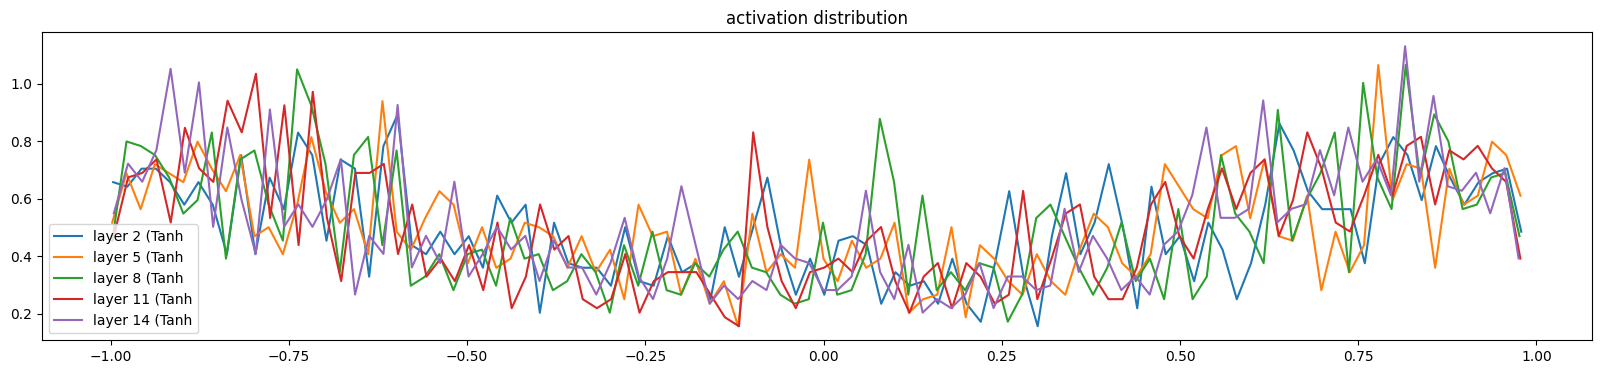

In [371]:
# visualize histograms
plt.figure(figsize=(20,4))
legends = []
for i, layer in enumerate(layers[:-1]): # exclude last layer
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100 ))
        hy, hx = torch.histogram(t, density=True)
        plt.plot( hx[:-1].detach(), hy.detach() )
        legends.append(f'layer {i} ({layer.__class__.__name__}')
        
plt.legend(legends)
plt.title('activation distribution')

layer 2 (      Tanh): mean -0.00, std 0.00
layer 5 (      Tanh): mean -0.00, std 0.00
layer 8 (      Tanh): mean +0.00, std 0.00
layer 11 (      Tanh): mean +0.00, std 0.00
layer 14 (      Tanh): mean -0.00, std 0.00


Text(0.5, 1.0, 'tanh gradient distribution')

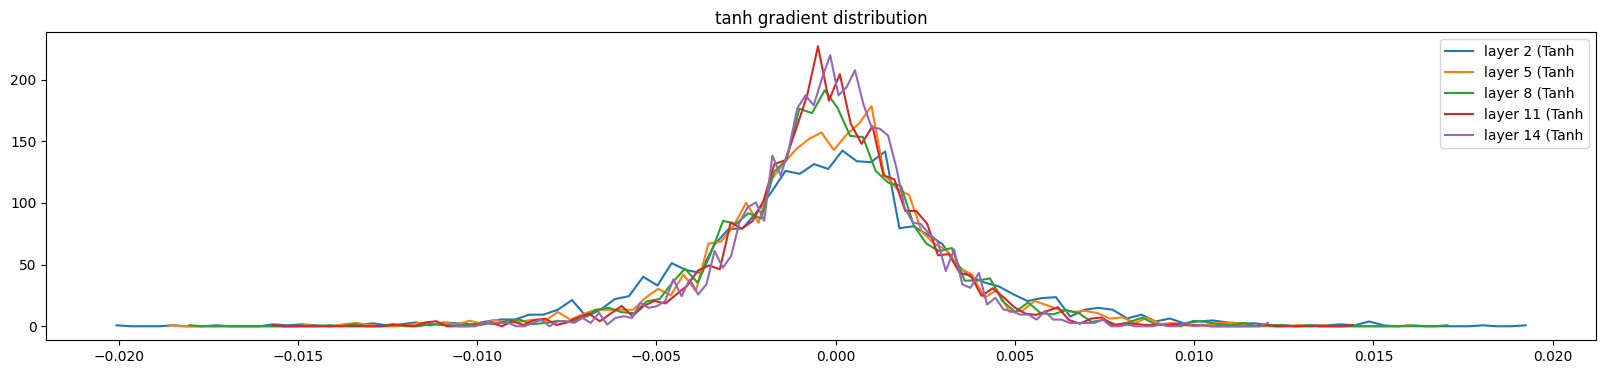

In [372]:
# visualize histograms
plt.figure(figsize=(20,4))
legends = []
for i, layer in enumerate(layers[:-1]): # exclude last layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+.2f, std %.2f' % (i, layer.__class__.__name__, t.mean(), t.std() ))
        hy, hx = torch.histogram(t, density=True)
        plt.plot( hx[:-1].detach(), hy.detach() )
        legends.append(f'layer {i} ({layer.__class__.__name__}')
        
plt.legend(legends)
plt.title('tanh gradient distribution')

weight   (27, 10) | mean -0.000000 | std 7.843944e-03 | grad:data ratio 7.403516e-03
weight  (30, 100) | mean -0.000443 | std 9.478916e-03 | grad:data ratio 3.165863e-02
weight (100, 100) | mean +0.000033 | std 8.022510e-03 | grad:data ratio 4.805256e-02
weight (100, 100) | mean -0.000021 | std 6.928096e-03 | grad:data ratio 4.103693e-02
weight (100, 100) | mean -0.000075 | std 6.996367e-03 | grad:data ratio 4.157448e-02
weight (100, 100) | mean -0.000035 | std 6.367775e-03 | grad:data ratio 3.829415e-02
weight  (100, 27) | mean +0.000121 | std 1.068397e-02 | grad:data ratio 6.471664e-02


Text(0.5, 1.0, 'weight gradient distribution')

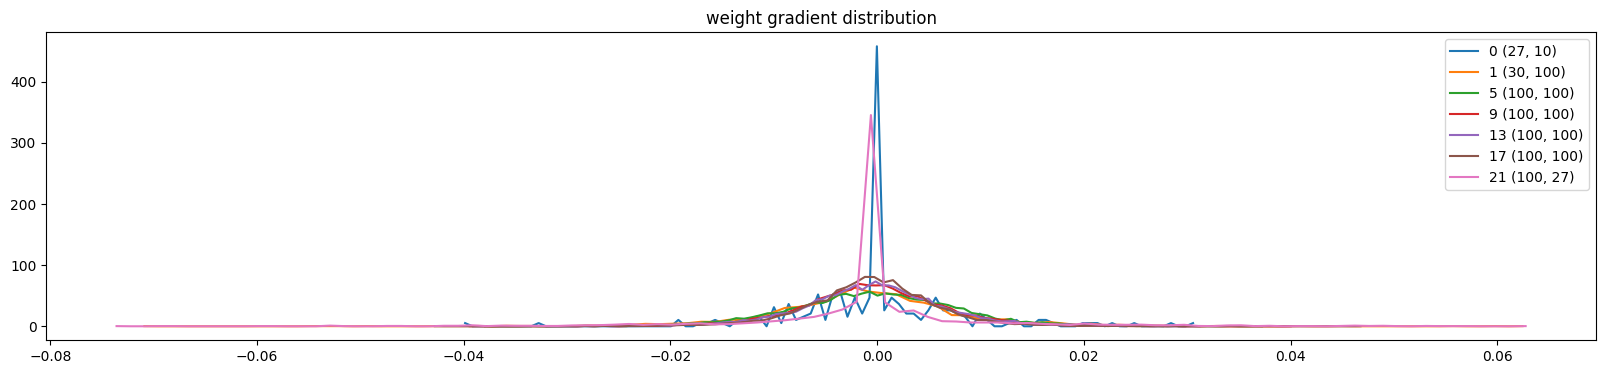

In [373]:
# visualize histograms
plt.figure(figsize=(20,4))
legends = []
for i, p in enumerate(parameters): # exclude last layer
    t = p.grad
    if p.ndim == 2:
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std() ))
        hy, hx = torch.histogram(t, density=True)
        plt.plot( hx[:-1].detach(), hy.detach() )
        legends.append(f'{i} {tuple(p.shape)}')
    
plt.legend(legends)
plt.title('weight gradient distribution')

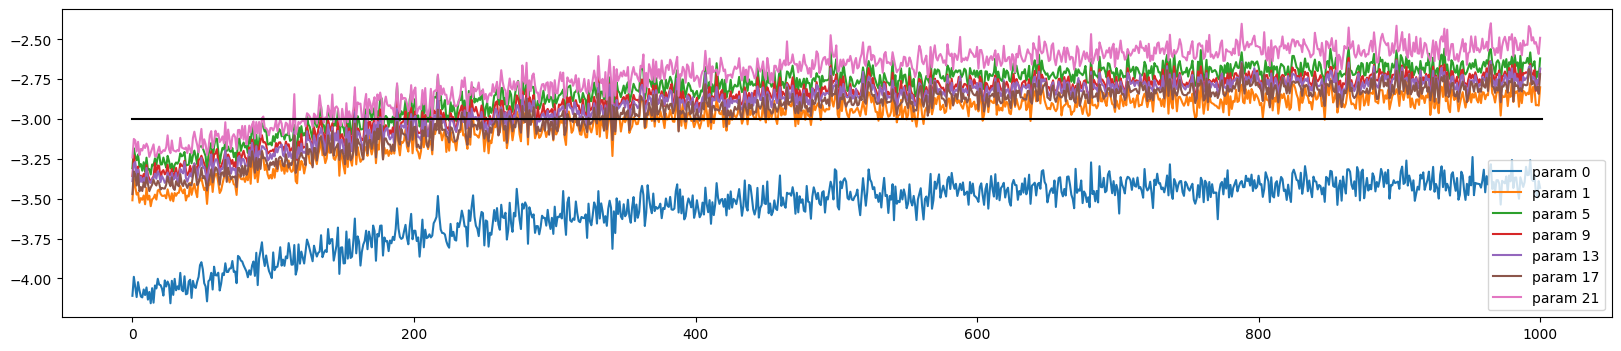

In [374]:
# update/weight ratio
# too small learning will be slow
# too big might not converge
plt.figure(figsize=(20,4))
legends = []

for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([
            ud[j][i] for j in range(len(ud))
        ])
        legends.append('param %d' % i)

plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3
plt.legend(legends)